In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [56]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, LSTM, Masking
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, binary_accuracy
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import AdamW
from model_helper import *
from pathlib import Path
from datetime import datetime


## 1. Load in dataset

In [3]:
cwd = Path().cwd()

In [4]:
with open(cwd.parent / "preprocessing" / "training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing" / "dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing" / "test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [73]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"]).reshape(-1, 1)
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"]).reshape(-1, 1)
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"]).reshape(-1, 1)
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20157, 12, 22)
Y_train shape: (20157, 1)
X_val shape: (2442, 12, 22)
Y_val shape: (2442, 1)
X_test shape: (2497, 12, 22)
Y_test shape: (2497, 1)


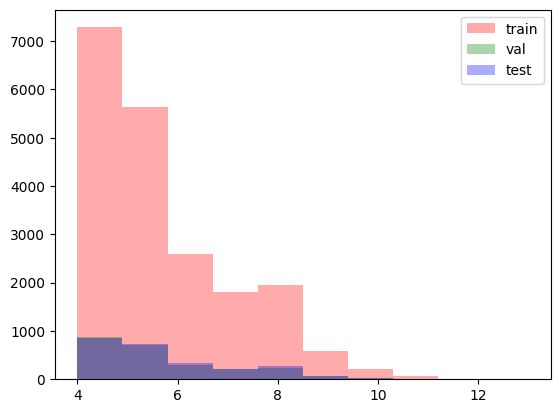

In [12]:
plt.hist(Y_train+4, color="red", alpha=0.33, label="train")
plt.hist(Y_val+4, color="green", alpha=0.33, label="val")
plt.hist(Y_test+4, color="blue", alpha=0.33, label="test")
plt.legend()
plt.show()


## 2. Define GradeNet Model

In [100]:
def GradeNet(n_holds=12):
    """Creates a keras model for the GradeNet architecture

    Returns:
        Model: GradeNet model
    """
    inputs = Input(shape=(n_holds, 22))
    mask = Masking(mask_value=0.0).compute_mask(inputs)
    lstm0 = LSTM(
        20,
        activation="tanh",
        input_shape=(n_holds, 22),
        kernel_initializer="glorot_normal",
        return_sequences="True",
    )(inputs, mask=mask)
    dense1 = Dense(100, activation="relu", kernel_initializer="glorot_normal")(lstm0)
    dense2 = Dense(80, activation="relu", kernel_initializer="glorot_normal")(dense1)
    dense3 = Dense(75, activation="relu", kernel_initializer="glorot_normal")(dense2)
    dense4 = Dense(50, activation="relu", kernel_initializer="glorot_normal")(dense3)
    dense5 = Dense(20, activation="relu", kernel_initializer="glorot_normal")(dense4)
    dense6 = Dense(10, activation="relu", kernel_initializer="glorot_normal")(dense5)
    flat = Flatten()(dense6)
    intermediate = Dense(1, name="intermediate")(flat)
    lstm1 = LSTM(
        20, activation="tanh", kernel_initializer="glorot_normal", return_sequences=True
    )(dense6)
    lstm2 = LSTM(20, activation="tanh", kernel_initializer="glorot_normal")(lstm1)
    dense7 = Dense(15, activation="relu", kernel_initializer="glorot_normal")(lstm2)
    dense8 = Dense(15, activation="relu", kernel_initializer="glorot_normal")(dense7)
    out = Dense(1, name="out")(dense8)

    return Model(inputs=[inputs], outputs=[out, intermediate])

In [96]:
BATCH_SIZE = 256


In [74]:
def one_off_accuracy(y_true, y_pred):
    """Computes the accuracy of a grade prediction including +/-1 errors

    Args:
        y_true: true grades
        y_pred: predicted grades
    """
    return tf.reduce_mean(tf.cast(abs(y_true - tf.math.round(y_pred)) <= 1, tf.float32))


In [77]:
# from tensorflow_addons.optimizers import CyclicalLearningRate

# step_size = 2 * len(X_train) // 32
# cyclical_learning_rate = CyclicalLearningRate(
#     initial_learning_rate=3e-7,
#     maximal_learning_rate=3e-5,
#     step_size=step_size,
#     scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
#     scale_mode="cycle",
# )

In [101]:
# TODO: re-enable custom loss, trying to get it to equal sum of intermediate and final loss
# def custom_loss(y_true, y_pred):
#     """Custom loss function with averages the final and interdiate (prior to lstm) losses"""
#     # TODO: what is the distinct benefit of intermediate loss for our use model
#     # Improved optimization: By including an additional cross-entropy loss at an intermediate layer, we provide the network with more information about the error signal and can help to prevent vanishing gradients, which can occur in deep networks. This can lead to more stable and efficient optimization during training.
#     # Better representation learning: Cross-entropy loss at an intermediate layer can encourage the network to learn better representations of the input data, which can improve the accuracy of the final predictions. This is because the intermediate layer may capture more complex and abstract features of the input data, which can be useful for discriminating between different classes.
#     # Regularization: Including an intermediate cross-entropy loss can also act as a form of regularization, by encouraging the network to learn representations that are more useful for classification. This can prevent overfitting and improve the generalization performance of the network.

#     # sparse cross entropy is used as y_true is encoded as integers not one-hot vectors
#     # returns cross entropy for each prediction
#     intermediate_loss = SparseCategoricalCrossentropy()(y_true, intermediate)
#     final_loss = SparseCategoricalCrossentropy()(y_true, y_pred)
#     # add the cross entropies and average over the predictions
#     return tf.reduce_mean(intermediate_loss + final_loss)

model = GradeNet()
model.compile(
    optimizer=AdamW(
        learning_rate=0.001,
        weight_decay=0.004,
        beta_1=0.9,
        beta_2=0.999,
    ),
    loss={
        "out": MeanSquaredError(),
        "intermediate": MeanSquaredError(),
    },
    metrics=[RootMeanSquaredError(), binary_accuracy, one_off_accuracy],
)

## 2-1. Training of GradeNet
### To load pretrained weights, please skip to 2-2.

In [102]:
# tensorboard callback
log_dir = cwd / "logs" / "GradeNet" / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint callback in case we manually end training early (o/w early stopping should restore best weights)
checkpoint_path = (
    cwd / "checkpoints" / "GradeNet" / "epoch{epoch:02d}-loss{val_loss:.2f}.h5"
)
cp_callback = ModelCheckpoint(
    filepath=str(checkpoint_path),
    save_weights_only=True,
    save_best_only=True,
    verbose=1,
)

# early stopping callback
es_callback = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
)

In [103]:
# TODO: where do the class weights come from, can we load them from a config?
# old {0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 4, 6: 2, 7: 4, 8: 8, 9: 8},
# new {0: 1, 1: 1, 2: 2, 3: 4, 4: 1, 5: 4, 6: 8, 7: 8, 8: 8, 9: 8},

# grade_weights = {0: 1, 1: 1, 2: 2, 3: 4, 4: 1, 5: 4, 6: 8, 7: 8, 8: 8, 9: 8}
history = model.fit(
    X_train,
    (Y_train, Y_train),
    validation_data=(X_val, (Y_val, Y_val)),
    epochs=40,
    batch_size=BATCH_SIZE,
    # class_weight=grade_weights,
    callbacks=[tensorboard_callback, cp_callback, es_callback],
)
# model.load_weights('GradeNet.h5')

Epoch 1/40
79/79 [==============================] - ETA: 0s - loss: 4.6096 - out_loss: 2.3929 - intermediate_loss: 2.2167 - out_root_mean_squared_error: 1.5469 - out_binary_accuracy: 0.3286 - out_one_off_accuracy: 0.7429 - intermediate_root_mean_squared_error: 1.4889 - intermediate_binary_accuracy: 0.3348 - intermediate_one_off_accuracy: 0.7427
Epoch 1: val_loss improved from inf to 2.44794, saving model to /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/GradeNet/epoch01-loss2.45.h5
79/79 [==============================] - 30s 162ms/step - loss: 4.6096 - out_loss: 2.3929 - intermediate_loss: 2.2167 - out_root_mean_squared_error: 1.5469 - out_binary_accuracy: 0.3286 - out_one_off_accuracy: 0.7429 - intermediate_root_mean_squared_error: 1.4889 - intermediate_binary_accuracy: 0.3348 - intermediate_one_off_accuracy: 0.7427 - val_loss: 2.4479 - val_out_loss: 1.1511 - val_intermediate_loss: 1.2969 - val_out_root_mean_squared_error: 1.0729 - val_out_binary_accuracy: 0.4472 - va

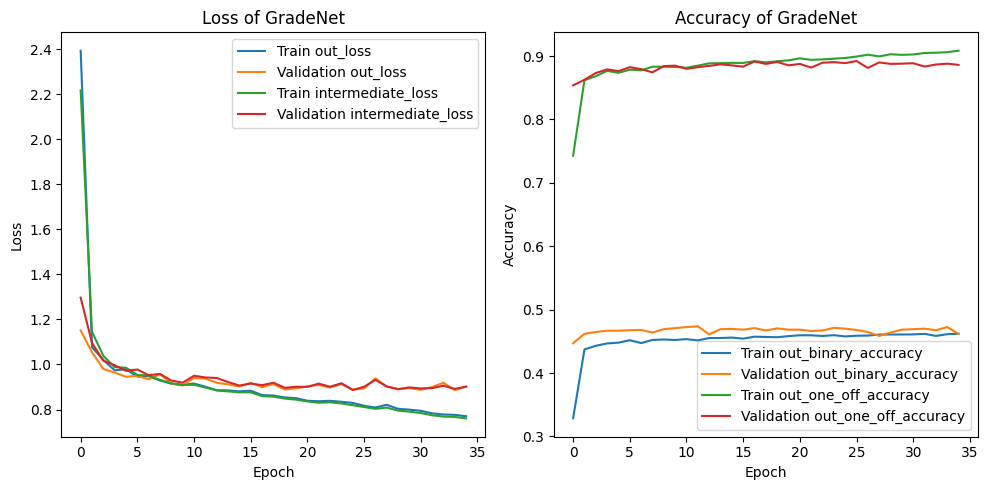

In [113]:
try:
    history_path = cwd / "GradeNet_train_history"
    plot_history(history, "GradeNet", losses=["out_loss", "intermediate_loss"], metrics=["out_binary_accuracy", "out_one_off_accuracy"])
    save_pickle(history, history_path)
except NameError:
    plot_tb_history(log_dir, "GradeNet")

| change              | optimal epoch | val_loss   | val_rmse  | val_acc    | val_one_off_acc |
| ------------------- | ------------- | ---------- | --------- | ---------- | --------------- |
| Adam                | 25            | 0.89241356 | 0.9446764 | 0.46846846 | 0.8890254       |
| AdamW               | 21            | 0.89716    | 0.9472    | 0.46150696 | 0.88533986      |
| + intermediate loss | 25            | 0.8886     | 0.9427    | 0.4701     | 0.8890          |


In [22]:
# load best checkpoint
best_cp = sorted(checkpoint_path.parent.glob("*.h5"), key=lambda p: float(p.stem.split("-")[1][4:]))[0]
best_cp

PosixPath('/mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/GradeNet/epoch25-loss0.89.h5')

In [62]:
model.load_weights(best_cp)

## 2.2 - Saving the model

In [40]:
model.save('GradeNet', include_optimizer=False)

INFO:tensorflow:Assets written to: GradeNet/assets


INFO:tensorflow:Assets written to: GradeNet/assets
